# Final Draft for Backend Integration
#### By - Arnav Ahuja

## Loading data

In [3]:
import pandas as pd
from datetime import datetime, timedelta

def load_data(csv_file):
    """
    Loads and preprocesses time series sensor data from a CSV file.

    Parameters:
        csv_file (str): Path to the CSV file containing the data.

    Returns:
        df (DataFrame): Processed DataFrame with standardized column names and datetime values.
        min_dp (int): Minimum data point index.
        max_dp (int): Maximum data point index.
        time_col (str): Name of the time reference column ("data_point").
    """
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Strip any whitespace from column names
    df.columns = df.columns.str.strip()

    # Standardize the first column as "data_point"
    original_time_col = df.columns[0]
    df.rename(columns={original_time_col: "data_point"}, inplace=True)

    # Replace the original time data with a sequential index
    df["data_point"] = list(range(len(df)))

    # Generate a datetime column assuming a uniform 10-minute interval starting from Jan 1, 2025
    df["datetime"] = [datetime(2025, 1, 1, 0, 0) + timedelta(minutes=10 * i) for i in range(len(df))]

    # Determine the min and max values of the data_point index
    min_dp = df["data_point"].min()
    max_dp = df["data_point"].max()

    # Return the processed DataFrame and metadata
    return df, min_dp, max_dp, "data_point"


## Normalizing data

In [6]:
import pandas as pd
import numpy as np

def normalize_data(df, time_col="data_point"):
    """
    Cleans and normalizes sensor data by removing empty values and interpolating missing readings.

    Parameters:
        df (DataFrame): The input DataFrame containing time series sensor data.
        time_col (str): The name of the column used as the time reference (default is "data_point").

    Returns:
        DataFrame: A cleaned and normalized DataFrame with time and numeric sensor values.
    """
    # Work on a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Drop rows and columns that are completely empty
    df.dropna(how='all', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)

    # Identify sensor columns (exclude time and datetime)
    sensor_cols = [col for col in df.columns if col not in [time_col, "datetime"]]

    # Keep only numeric sensor columns
    numeric_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

    # Interpolate missing values linearly (forward and backward)
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='both')

    # Drop rows that still contain any missing values
    df.dropna(how='any', inplace=True)

    # Return the cleaned DataFrame with only relevant columns
    return df[[time_col, "datetime"] + numeric_cols]


## Calculating Sliding Correlations

In [9]:
def compute_sliding_correlations(df, window_size, time_col="data_point"):
    """
    Computes pairwise Pearson correlation coefficients between sensor streams
    using a sliding window approach.

    Parameters:
        df (DataFrame): The normalized time series DataFrame.
        window_size (int): The number of rows (time steps) in each sliding window.
        time_col (str): The name of the time index column (default is "data_point").

    Returns:
        dict: A dictionary where keys are tuples of sensor pairs (col1, col2),
              and values are lists of correlation coefficients computed over each window.
    """
    # Get the list of sensor columns (excluding time and datetime)
    stream_cols = df.columns.drop([time_col, "datetime"])

    correlations = {}

    # Iterate over all unique pairs of sensor columns
    for i in range(len(stream_cols)):
        for j in range(i + 1, len(stream_cols)):
            pair = (stream_cols[i], stream_cols[j])
            corrs = []

            # Slide the window across the data and compute correlation
            for start in range(0, len(df) - window_size + 1):
                window = df.iloc[start:start + window_size]
                corr = window[stream_cols[i]].corr(window[stream_cols[j]])
                corrs.append(corr)

            # Store correlation values for the sensor pair
            correlations[pair] = corrs

    return correlations


## Calculating Single Correlation

In [12]:
def compute_correlation_in_window(df, col1, col2, start_dt, end_dt):
    """
    Computes the Pearson correlation between two sensor columns within a specified datetime range.

    Parameters:
        df (DataFrame): The normalized time series DataFrame.
        col1 (str): Name of the first sensor column.
        col2 (str): Name of the second sensor column.
        start_dt (datetime): Start of the time window (inclusive).
        end_dt (datetime): End of the time window (inclusive).

    Returns:
        float: Pearson correlation coefficient between col1 and col2 within the given datetime range.
    """
    # Create a mask to filter rows within the specified datetime range
    mask = (df['datetime'] >= start_dt) & (df['datetime'] <= end_dt)

    # Extract the relevant subset of the DataFrame
    sub_df = df.loc[mask, [col1, col2]]

    # Compute and return the Pearson correlation
    return sub_df[col1].corr(sub_df[col2])


## Plotting Correlation Values

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_correlations(df, correlations, window_size):
    """
    Plots the sliding window correlation values for each pair of sensor streams.

    Parameters:
        df (DataFrame): The original or normalized DataFrame containing the "data_point" column.
        correlations (dict): Dictionary of correlation results from compute_sliding_correlations().
                             Keys are sensor column pairs (tuple), values are lists of correlation values.
        window_size (int): The window size used in computing the correlations (for padding purposes).

    Returns:
        None
    """
    # Use the time reference column for x-axis
    t = df["data_point"].values

    # Initialize plot
    plt.figure(figsize=(12, 6))

    # Plot each sensor pair's correlation curve
    for (s1, s2), corr_values in correlations.items():
        # Pad the correlation list so it aligns with the original time points
        padded_corr = [np.nan] * (window_size - 1) + corr_values
        plt.plot(t, padded_corr, label=f"Corr({s1},{s2})")

    # Add labels and formatting
    plt.title("Sliding Window Correlations")
    plt.xlabel("Data Point")
    plt.ylabel("Correlation")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Plotting Pairwise Sensor Data

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pairwise_highlighted(df, selected_streams, start_dt, end_dt):
    """
    Plots each unique pair of selected sensor streams with their values over time,
    highlighting the specified datetime window and displaying the correlation within that window.

    Parameters:
        df (DataFrame): The normalized time series DataFrame with a "datetime" column.
        selected_streams (list): List of selected sensor column names (e.g., ["s1", "s2", "s3"]).
        start_dt (datetime): Start of the highlighted time window.
        end_dt (datetime): End of the highlighted time window.

    Returns:
        None
    """
    # Iterate over all unique pairs of selected sensor streams
    for i in range(len(selected_streams)):
        for j in range(i + 1, len(selected_streams)):
            s1, s2 = selected_streams[i], selected_streams[j]

            # Create a new figure for each pair
            fig, ax = plt.subplots(figsize=(10, 5))

            # Plot sensor values over time
            ax.plot(df["datetime"], df[s1], label=s1)
            ax.plot(df["datetime"], df[s2], label=s2)

            # Highlight the selected datetime window
            ax.axvspan(start_dt, end_dt, color='orange', alpha=0.3)

            # Compute correlation in the highlighted window
            corr = compute_correlation_in_window(df, s1, s2, start_dt, end_dt)

            # Annotate the plot with the correlation value
            ax.text(0.01, 0.95, f"Corr({s1},{s2}) = {corr:.3f}", transform=ax.transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.6))

            # Set plot titles and labels
            ax.set_title(f"{s1} vs {s2} with Highlighted Window")
            ax.set_xlabel("Datetime")
            ax.set_ylabel("Sensor Value")
            ax.legend()

            # Adjust layout and display the plot
            fig.tight_layout()
            plt.show()


## Saving Correlation to CSV

In [21]:
import os

def save_correlations(df, correlations, output_dir):
    """
    Saves the original DataFrame along with padded sliding window correlation columns
    for each pair of sensor streams to a CSV file.

    Parameters:
        df (DataFrame): The input DataFrame containing time, datetime, and sensor values.
        correlations (dict): Dictionary containing correlation lists keyed by sensor column pairs.
        output_dir (str): Directory path where the output CSV should be saved.

    Returns:
        None
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_to_save = df.copy()

    # Add each correlation result as a new column
    for (s1, s2), corr_values in correlations.items():
        # Construct a short column name for the pair (e.g., c(1, 2))
        col_name = f"c({s1[-1]}, {s2[-1]})"

        # Pad the correlation list to align with the full DataFrame length
        padded_corr = [None] * (len(df_to_save) - len(corr_values)) + corr_values

        # Add the padded correlation values as a new column
        df_to_save[col_name] = padded_corr

    # Define the full output path and save the DataFrame as CSV
    output_path = os.path.join(output_dir, "complex_formatted.csv")
    df_to_save.to_csv(output_path, index=False)

    # Notify the user of the saved file
    print(f"Saved: {output_path}")


## Setup GUI

In [24]:
import tkinter as tk
from tkinter import ttk
from tkcalendar import DateEntry
from datetime import datetime, timedelta
import os

def setup_gui(min_datetime, max_datetime, process_callback):
    """
    Builds a GUI for selecting a time range, window size, and sensor streams
    with valid constraints based on available data. Syncs user input via both
    entry boxes and dropdowns to avoid invalid selections.

    Parameters:
        min_datetime (datetime): Earliest timestamp in the dataset.
        max_datetime (datetime): Latest timestamp in the dataset.
        process_callback (function): Callback to execute on user submission.
    """
    root = tk.Tk()
    root.title("Time Range & Stream Selector + Correlation Viewer")
    root.geometry("600x250")
    root.configure(bg="#f9f9f9")

    # --- Styling ---
    style = ttk.Style()
    style.configure("TLabel", font=("Segoe UI", 10, "bold"), background="#f9f9f9")
    style.configure("TButton", font=("Segoe UI", 10))
    style.configure("TCheckbutton", font=("Segoe UI", 10), background="#f9f9f9")

    # --- Time restriction helpers ---
    def get_allowed_hours(date, for_start):
        if date == min_datetime.date() and date == max_datetime.date():
            return [f"{h:02d}" for h in range(min_datetime.hour, max_datetime.hour + 1)]
        elif for_start and date == min_datetime.date():
            return [f"{h:02d}" for h in range(min_datetime.hour, 24)]
        elif not for_start and date == max_datetime.date():
            return [f"{h:02d}" for h in range(0, max_datetime.hour + 1)]
        return [f"{h:02d}" for h in range(0, 24)]

    def get_allowed_minutes(date, hour, for_start):
        hour = int(hour)
        if date == min_datetime.date() and date == max_datetime.date():
            if hour == min_datetime.hour and hour == max_datetime.hour:
                return [f"{m:02d}" for m in range(min_datetime.minute, max_datetime.minute + 1)]
            elif hour == min_datetime.hour:
                return [f"{m:02d}" for m in range(min_datetime.minute, 60)]
            elif hour == max_datetime.hour:
                return [f"{m:02d}" for m in range(0, max_datetime.minute + 1)]
        elif for_start and date == min_datetime.date() and hour == min_datetime.hour:
            return [f"{m:02d}" for m in range(min_datetime.minute, 60)]
        elif not for_start and date == max_datetime.date() and hour == max_datetime.hour:
            return [f"{m:02d}" for m in range(0, max_datetime.minute + 1)]
        return [f"{m:02d}" for m in range(0, 60)]

    def get_allowed_seconds(date, hour, minute, for_start):
        hour = int(hour)
        minute = int(minute)
        if date == min_datetime.date() and date == max_datetime.date():
            if hour == min_datetime.hour and minute == min_datetime.minute and hour == max_datetime.hour and minute == max_datetime.minute:
                return [f"{s:02d}" for s in range(min_datetime.second, max_datetime.second + 1)]
            elif hour == min_datetime.hour and minute == min_datetime.minute:
                return [f"{s:02d}" for s in range(min_datetime.second, 60)]
            elif hour == max_datetime.hour and minute == max_datetime.minute:
                return [f"{s:02d}" for s in range(0, max_datetime.second + 1)]
        elif for_start and date == min_datetime.date() and hour == min_datetime.hour and minute == min_datetime.minute:
            return [f"{s:02d}" for s in range(min_datetime.second, 60)]
        elif not for_start and date == max_datetime.date() and hour == max_datetime.hour and minute == max_datetime.minute:
            return [f"{s:02d}" for s in range(0, max_datetime.second + 1)]
        return [f"{s:02d}" for s in range(0, 60)]

    # --- START datetime widgets ---
    ttk.Label(root, text="Start Date:").grid(row=0, column=0)
    start_date = DateEntry(root, date_pattern="y-mm-dd", mindate=min_datetime.date(), maxdate=max_datetime.date())
    start_date.set_date(min_datetime.date())
    start_date.grid(row=0, column=1)

    ttk.Label(root, text="Start Time:").grid(row=0, column=2)
    start_hour = ttk.Combobox(root, width=3)
    start_min = ttk.Combobox(root, width=3)
    start_sec = ttk.Combobox(root, width=3)
    start_hour.grid(row=0, column=3)
    start_min.grid(row=0, column=4)
    start_sec.grid(row=0, column=5)

    # --- END datetime widgets ---
    ttk.Label(root, text="End Date:").grid(row=1, column=0)
    end_date = DateEntry(root, date_pattern="y-mm-dd", mindate=min_datetime.date(), maxdate=max_datetime.date())
    end_date.set_date(max_datetime.date())
    end_date.grid(row=1, column=1)

    ttk.Label(root, text="End Time:").grid(row=1, column=2)
    end_hour = ttk.Combobox(root, width=3)
    end_min = ttk.Combobox(root, width=3)
    end_sec = ttk.Combobox(root, width=3)
    end_hour.grid(row=1, column=3)
    end_min.grid(row=1, column=4)
    end_sec.grid(row=1, column=5)

    # --- Window Size Entry + Slider ---
    ttk.Label(root, text="Window Size:").grid(row=2, column=0, padx=10, pady=10)
    window_size_box = ttk.Entry(root, width=6)
    window_size_box.insert(0, "15")
    window_size_box.grid(row=2, column=1)

    window_slider = tk.Scale(root, from_=1, to=500, orient=tk.HORIZONTAL, length=200, bg="#f9f9f9")
    window_slider.set(15)
    window_slider.grid(row=2, column=2, columnspan=3, padx=5)

    def sync_slider(*args):
        try:
            window_slider.set(int(window_size_box.get()))
        except ValueError:
            pass

    def sync_box(val):
        window_size_box.delete(0, tk.END)
        window_size_box.insert(0, str(int(float(val))))

    window_size_box.bind("<KeyRelease>", lambda e: sync_slider())
    window_slider.config(command=sync_box)

    # --- Stream selection checkboxes ---
    ttk.Label(root, text="Select Streams:").grid(row=3, column=0, padx=10, pady=10)
    stream_vars = {}
    for idx, stream in enumerate(["s1", "s2", "s3"]):
        var = tk.BooleanVar(value=True)
        chk = ttk.Checkbutton(root, text=stream, variable=var)
        chk.grid(row=3, column=1 + idx)
        stream_vars[stream] = var

    # --- Dynamic option refresh logic ---
    def refresh_start(*_):
        d = start_date.get_date()
        h_vals = get_allowed_hours(d, True)
        start_hour["values"] = h_vals
        start_hour.set(h_vals[0])
        refresh_start_min()

    def refresh_start_min(*_):
        d = start_date.get_date()
        h = start_hour.get()
        m_vals = get_allowed_minutes(d, h, True)
        start_min["values"] = m_vals
        start_min.set(m_vals[0])
        refresh_start_sec()

    def refresh_start_sec(*_):
        d = start_date.get_date()
        h = start_hour.get()
        m = start_min.get()
        s_vals = get_allowed_seconds(d, h, m, True)
        start_sec["values"] = s_vals
        start_sec.set(s_vals[0])

    def refresh_end(*_):
        d = end_date.get_date()
        h_vals = get_allowed_hours(d, False)
        end_hour["values"] = h_vals
        end_hour.set(h_vals[-1])
        refresh_end_min()

    def refresh_end_min(*_):
        d = end_date.get_date()
        h = end_hour.get()
        m_vals = get_allowed_minutes(d, h, False)
        end_min["values"] = m_vals
        end_min.set(m_vals[-1])
        refresh_end_sec()

    def refresh_end_sec(*_):
        d = end_date.get_date()
        h = end_hour.get()
        m = end_min.get()
        s_vals = get_allowed_seconds(d, h, m, False)
        end_sec["values"] = s_vals
        end_sec.set(s_vals[-1])

    # --- Event triggers ---
    for w in [start_date, end_date]: w.bind("<<DateEntrySelected>>", lambda e: [refresh_start(), refresh_end()])
    for w in [start_hour, start_min]: w.bind("<<ComboboxSelected>>", lambda e: refresh_start_sec())
    for w in [end_hour, end_min]: w.bind("<<ComboboxSelected>>", lambda e: refresh_end_sec())

    refresh_start()
    refresh_end()

    # --- Display button ---
    def on_click():
        process_callback(window_size_box, start_date, start_hour, start_min, start_sec,
                         end_date, end_hour, end_min, end_sec, stream_vars)

    ttk.Button(root, text="Display", command=on_click).grid(row=5, column=0, columnspan=6, pady=20)

    root.mainloop()


## Callback Function

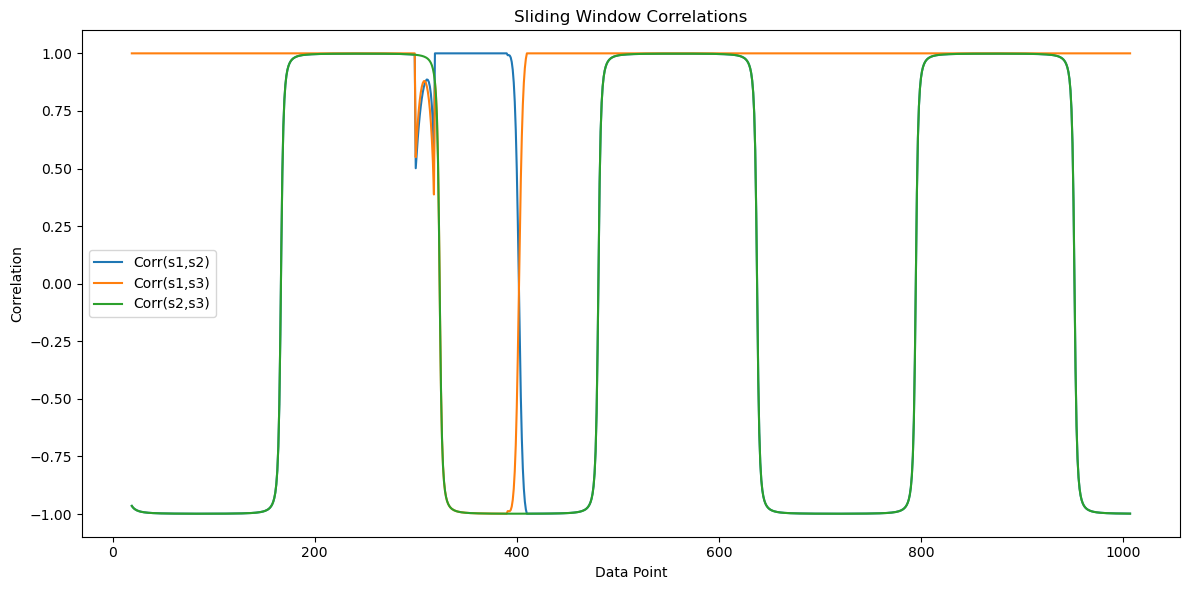

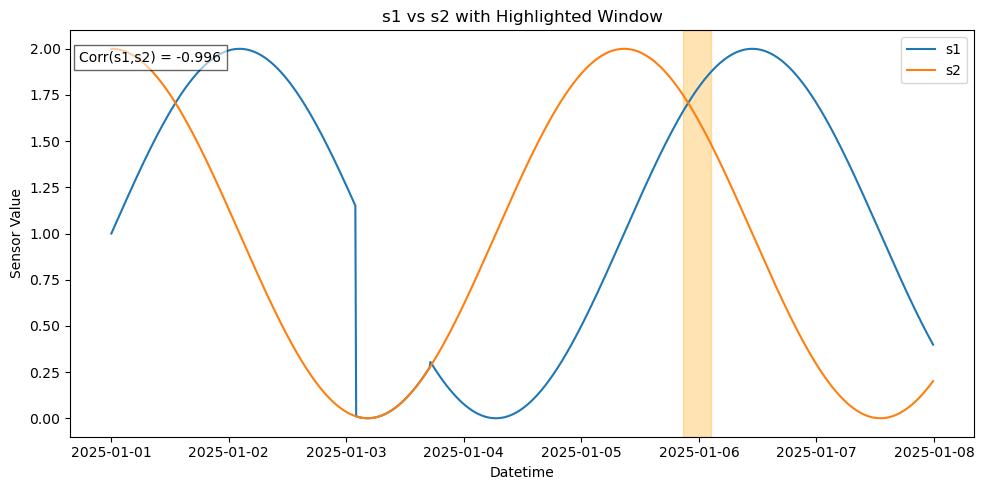

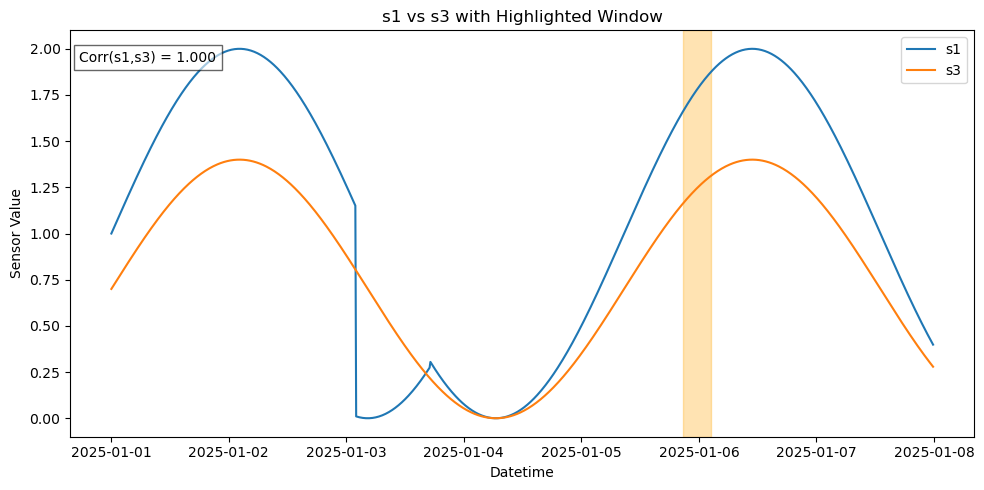

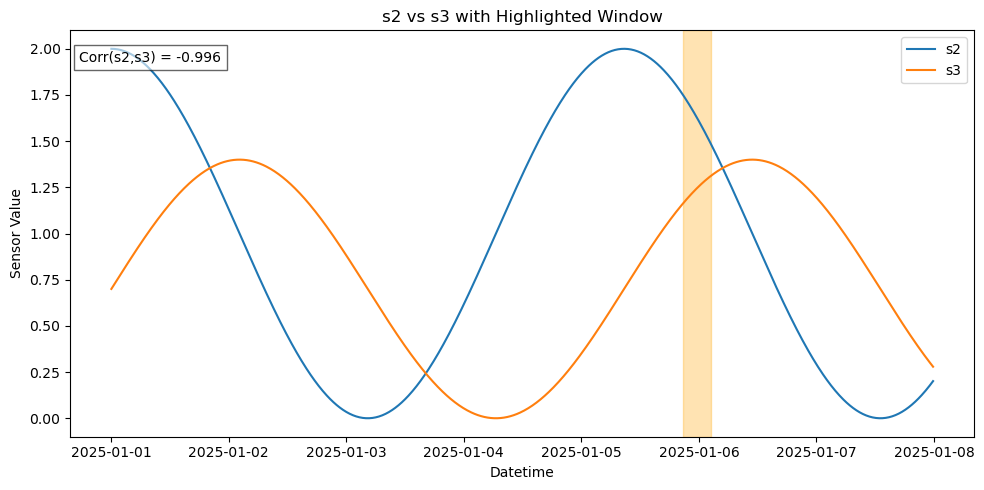

Saved: complex_formatted.csv


In [27]:
def process_callback(window_size_box,
                     start_date, start_hour, start_minute, start_second,
                     end_date, end_hour, end_minute, end_second,
                     stream_vars):
    """
    Callback function triggered when the user clicks the 'Display' button in the GUI.
    Handles the extraction of user input, computation of correlations, visualization,
    and saving of results.

    Parameters:
        window_size_box (Entry): Entry widget containing the sliding window size.
        start_date, end_date (DateEntry): Start and end date selectors.
        start_hour, start_minute, start_second (Combobox): Start time selectors.
        end_hour, end_minute, end_second (Combobox): End time selectors.
        stream_vars (dict): Dictionary of sensor stream BooleanVars indicating user selection.

    Returns:
        None
    """
    # --- Parse and validate window size ---
    try:
        window_size = int(window_size_box.get())
    except ValueError:
        print("Invalid window size")
        return

    # --- Extract selected sensor columns ---
    selected_streams = [stream for stream, var in stream_vars.items() if var.get()]
    df_selected = df_raw[["data_point", "datetime"] + selected_streams]

    # --- Normalize selected data ---
    df_normalized = normalize_data(df_selected, time_col="data_point")

    # --- Compute sliding window correlations ---
    correlations = compute_sliding_correlations(df_normalized, window_size)

    # --- Plot correlation curves for all pairs ---
    plot_all_correlations(df_normalized, correlations, window_size)

    # --- Parse datetime ranges from GUI ---
    start_dt = datetime.combine(start_date.get_date(), datetime.strptime(
        f"{start_hour.get()}:{start_minute.get()}:{start_second.get()}", "%H:%M:%S").time())
    end_dt = datetime.combine(end_date.get_date(), datetime.strptime(
        f"{end_hour.get()}:{end_minute.get()}:{end_second.get()}", "%H:%M:%S").time())

    # --- Plot selected pairs with the highlighted datetime window ---
    plot_pairwise_highlighted(df_normalized, selected_streams, start_dt, end_dt)

    # --- Save correlation results to CSV file ---
    save_correlations(df_normalized, correlations, output_dir=os.path.dirname("complex.csv"))


# ---------- Load Data ----------
# Load the initial dataset and derive datetime boundaries for the GUI
df_raw, min_dp, max_dp, time_col = load_data("complex.csv")
min_datetime = df_raw["datetime"].min()
max_datetime = df_raw["datetime"].max()

# Launch the GUI with dynamically constrained date/time selection
setup_gui(min_datetime, max_datetime, process_callback)
